### Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import os
import random
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from tqdm import tqdm
from time import sleep
from collections import OrderedDict
from more_itertools import chunked

n_shot = 1
n_class = 10
n_local_update = 5
batch_size = n_class

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# TODO ↓消す
def batchnorm(input, weight=None, bias=None, running_mean=None, running_var=None, training=True, eps=1e-5, momentum=0.1):
    ''' momentum = 1 restricts stats to the current mini-batch '''
    # This hack only works when momentum is 1 and avoids needing to track running stats
    # by substuting dummy variables
    running_mean = torch.zeros(np.prod(np.array(input.data.size()[1]))).cuda()
    running_var = torch.ones(np.prod(np.array(input.data.size()[1]))).cuda()
    return F.batch_norm(input, running_mean, running_var, weight, bias, training, momentum, eps)


class OmniglotNet(nn.Module):
    def __init__(self, n_class):
        super(OmniglotNet, self).__init__()
        
        self.h=64
        self.conv1 = nn.Conv2d(1, self.h, kernel_size=3)
        self.conv2 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.conv3 = nn.Conv2d(self.h, self.h, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn2 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.bn3 = nn.BatchNorm2d(self.h, momentum=1, affine=True)
        self.fc = nn.Linear(self.h, n_class)

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.view(x.size(0), self.h)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        
        return x

    # for MAML local optimize
    def manual_forward(self, x, params):
        
        x = F.conv2d(x, params['conv1.weight'].to(device), params['conv1.bias'].to(device))
        x = batchnorm(x, weight = params['bn1.weight'], bias = params['bn1.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv2.weight'].to(device), params['conv2.bias'].to(device))
        x = batchnorm(x, weight = params['bn2.weight'], bias = params['bn2.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = F.conv2d(x, params['conv3.weight'].to(device), params['conv3.bias'].to(device))
        x = batchnorm(x, weight = params['bn3.weight'], bias = params['bn3.bias'], momentum=1)
        x = F.max_pool2d(F.relu(x), 2)
        
        x = x.view(x.size(0), self.h)
        x = F.linear(x, params['fc.weight'].to(device), params['fc.bias'].to(device))
        x = F.log_softmax(x, dim=1)
        
        return x
    
    
def train(model, device, train_data_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for data, target in train_data_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        pred = output.max(1, keepdim=True)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += pred.eq(target.view_as(pred)).sum().item()
    
    train_loss /= len(train_data_loader.dataset)
    train_acc /= len(train_data_loader.dataset)
    return train_loss, train_acc

def test(model, device, test_data_loader):
    model.eval()
    test_loss = 0
    test_acc = 0
    
    with torch.no_grad():
        for data, target in test_data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            
            test_loss += loss
            test_acc += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_data_loader.dataset)
    test_acc /= len(test_data_loader.dataset)
    return test_loss, test_acc

### Dataset

In [2]:
class OmniglotOriginDataset(Dataset):
    def __init__(self, path_to_lang, n_class, train, train_index, transform):

        self.data = []
        self.path = path_to_lang
        
        labels = sorted(os.listdir(path_to_lang))[:n_class]
        
        for label_i, label in enumerate(labels):
            path_to_label = os.path.join(path_to_lang, label)
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### AugmentedDataset

In [3]:
class OmniglotAugmentedDataset(Dataset):
    def __init__(self, path_to_chars, train, train_indices, transform):

        self.data = []
        self.path = NotImplementedError
        
        for label_i, (path_to_label, train_index) in enumerate(zip(path_to_chars, train_indices)):
            chars = np.array(sorted(os.listdir(path_to_label)))
            if train:
                chars = chars[train_index]
            else:
                test_index = list(set(np.arange(20)) - set(train_index)) # 各文字20枚ずつ入ってる
                chars = chars[test_index]
            for char in chars:
                path_to_char = os.path.join(path_to_label, char)
                image = io.imread(path_to_char)
                label_i = np.array(label_i)
                self.data.append([image, label_i])
            
        self.transform = transform
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1]
        image = image / 255
        image = image.reshape([28,28, 1])
        image = image.transpose((2, 0, 1))
        image = np.array(image, np.float32)

        return [torch.from_numpy(image), torch.from_numpy(label)]

### DataLoader

../data/omniglot_mini/images_background/Latin/


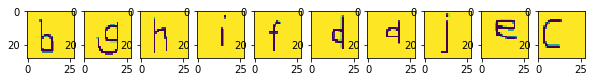

y_true: tensor([1, 6, 7, 8, 5, 3, 0, 9, 4, 2])


In [4]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

print(local_task_train_data_loader.dataset.path)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

### AugmentDataLoader

local_task_train_data


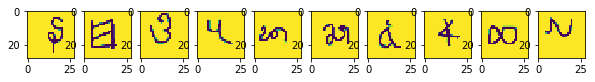

y_true: tensor([4, 0, 7, 6, 3, 5, 9, 2, 8, 1])

local_task_train_data


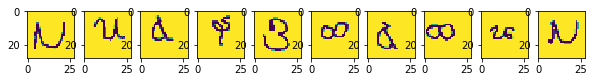

y_true: tensor([1, 6, 9, 4, 7, 8, 9, 8, 3, 1])


In [5]:
train_indices = np.random.randint(20, size=(n_class, n_shot))

path_to_chars = [
    '../data/omniglot_mini/images_background/Early_Aramaic/character08',
    '../data/omniglot_mini/images_background/N_Ko/character05',
    '../data/omniglot_mini/images_background/Early_Aramaic/character01',
    '../data/omniglot_mini/images_background/Balinese/character04',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character21',
    '../data/omniglot_mini/images_background/Balinese/character03',
    '../data/omniglot_mini/images_background/Gujarati/character35',
    '../data/omniglot_mini/images_background/Bengali/character10',
    '../data/omniglot_mini/images_background/Burmese_(Myanmar)/character18',
    '../data/omniglot_mini/images_background/Armenian/character17'
]

print("local_task_train_data")
local_task_train_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=True,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_train_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)

print("\nlocal_task_train_data")
local_task_test_data_loader = DataLoader(
    OmniglotAugmentedDataset(path_to_chars,
                    train=False,
                    train_indices=train_indices,
                    transform=transforms.Compose([
                        ToTensor(),
                    ])),
    batch_size=batch_size, shuffle=True)

for data, target in local_task_test_data_loader: # only have one batch
    plt.figure(figsize=(10,1))
    for i, x in enumerate(data):
        plt.subplot(1, batch_size, i+1); plt.imshow(x[0])
    plt.show()
    print("y_true:", target)
    break

### (fitting, task=Latin, n_class=10, n_shot=1)

100%|██████████| 10/10 [00:00<00:00, 49.54it/s, epoch=10, train_loss=0.0878, train_acc=1, test_loss=2.07, test_acc=0.311]


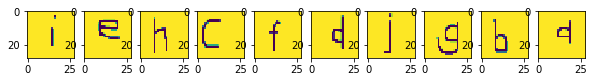

y_pred: tensor([8, 4, 7, 2, 5, 3, 9, 6, 1, 0])
y_true: tensor([8, 4, 7, 2, 5, 3, 9, 6, 1, 0])


In [6]:
local_task_train_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=True,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)


local_task_test_data_loader = DataLoader(
    OmniglotOriginDataset("../data/omniglot_mini/images_background/Latin/", 
                    n_class=n_class,
                    train=False,
                    train_index=[0],
                    transform=transforms.Compose([
                        ToTensor()
                    ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(10)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### (fitting, task=MNIST, n_class=10, n_shot=1)

100%|██████████| 1/1 [00:15<00:00, 15.39s/it, epoch=1, train_loss=0.0147, train_acc=0.963, test_loss=0.0679, test_acc=0.979]


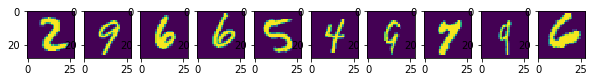

y_pred: tensor([2, 9, 6, 6, 5, 4, 9, 7, 9, 6])
y_true: tensor([2, 9, 6, 6, 5, 4, 9, 7, 9, 6])


In [7]:
local_task_train_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

local_task_test_data_loader = DataLoader(
    datasets.MNIST('../data/mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)

model = OmniglotNet(n_class=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

with tqdm(range(1)) as _tqdm:
    for epoch in _tqdm:
        train_loss, train_acc = train(model, device, local_task_train_data_loader, optimizer, epoch)
        test_loss, test_acc = test(model, device, local_task_test_data_loader)
        _tqdm.set_postfix(OrderedDict(
            epoch=epoch+1, 
            train_loss=train_loss, train_acc=train_acc, 
            test_loss=test_loss, test_acc=test_acc))
        

data, target = local_task_train_data_loader.__iter__().next()

images = np.array(data).reshape(10,28,28)
plt.figure(figsize=(10,1))
[[plt.subplot(1,10,i+1), plt.imshow(img)] for i, img in enumerate(images)]; plt.show()

print("y_pred:", torch.argmax(model(data.cuda()), 1).cpu())
print("y_true:", target)

### Taskset and TaskLoader classes

In [4]:
class Taskset(object):
    def __getitem__(self, index):
        raise NotImplementedError
    def __len__(self):
        raise NotImplementedError

class TaskLoader(object):
    def __init__(self, taskset, shuffle=True):
        self.taskset = taskset
        self.sample_iter = iter(np.random.permutation(np.arange(len(taskset))))
    def __iter__(self):
        return self
    def __next__(self):
        return self.taskset[next(self.sample_iter)]
    def __len__(self):
        return len(self.taskset)

### Taskset

In [5]:
class OmniglotOriginTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
        
        langs = sorted(os.listdir(path_to_langs))
        tasks = [os.path.join(path_to_langs, lang) for lang in langs]
        tasks = [task for task in tasks if len(os.listdir(task))>=n_class]
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_index=[np.random.randint(20)] #TODO chanege indices
        return {"train":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx], 
                                    n_class=n_class,
                                    train=True,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotOriginDataset(self.tasks[idx],
                                    n_class=n_class,
                                    train=False,
                                    train_index=train_index,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### AugmentedTaskset

In [6]:
class OmniglotAugmentedTaskset(Taskset):
    def __init__(self, path_to_omniglot, n_class, n_shot, meta_train):
        
        if meta_train:
            path_to_langs = os.path.join(path_to_omniglot, "images_background/")
        else:
            path_to_langs = os.path.join(path_to_omniglot, "images_evaluation/")
            
        chars = []
        
        for path_to_lang in os.listdir(path_to_langs):
            path_to_chars = os.path.join(path_to_langs, path_to_lang)
            for path_to_char in os.listdir(path_to_chars):
                chars.append(os.path.join(path_to_chars, path_to_char)) 
        
        random.shuffle(chars)
        tasks = list(chunked(chars, n_class))[:-1] # drop_last
        
        self.tasks = tasks
    
    def __len__(self):
        return len(self.tasks)
    
    def __getitem__(self, idx):
        train_indices = np.random.randint(20, size=(n_class, n_shot))
        return {"train":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=True,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True), 
                "test":
                DataLoader(
                    OmniglotAugmentedDataset(self.tasks[idx],
                                    train=False,
                                    train_indices=train_indices,
                                    transform=transforms.Compose([
                                        ToTensor()
                                    ])),
                    batch_size=batch_size, shuffle=True),
                "task": self.tasks[idx] 
               }

### TaskLoader

30
../data/omniglot_mini/images_background/Anglo-Saxon_Futhorc


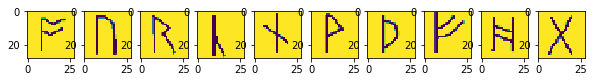

tensor([3, 1, 4, 5, 9, 7, 2, 0, 8, 6])
../data/omniglot_mini/images_background/Cyrillic


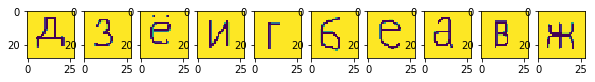

tensor([4, 8, 6, 9, 3, 1, 5, 0, 2, 7])
../data/omniglot_mini/images_background/Malay_(Jawi_-_Arabic)


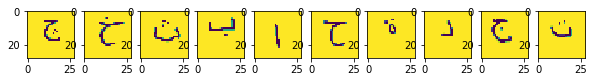

tensor([7, 8, 4, 1, 0, 6, 3, 9, 5, 2])


In [7]:
meta_train_task_loader = TaskLoader(
    OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    if i==2:
        break

### AugmentTaskLoader

96
['../data/omniglot_mini/images_background/Early_Aramaic/character18', '../data/omniglot_mini/images_background/Bengali/character46', '../data/omniglot_mini/images_background/Arcadian/character08', '../data/omniglot_mini/images_background/Latin/character02', '../data/omniglot_mini/images_background/Braille/character13', '../data/omniglot_mini/images_background/Japanese_(katakana)/character33', '../data/omniglot_mini/images_background/Armenian/character23', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character05', '../data/omniglot_mini/images_background/N_Ko/character13', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character49']
train


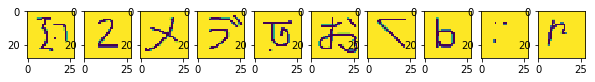

tensor([2, 6, 5, 9, 1, 7, 8, 3, 4, 0])
test


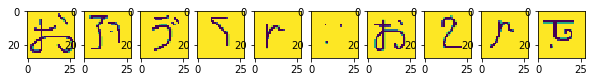

tensor([7, 2, 9, 8, 0, 4, 7, 6, 0, 1])
['../data/omniglot_mini/images_background/Asomtavruli_(Georgian)/character04', '../data/omniglot_mini/images_background/Bengali/character23', '../data/omniglot_mini/images_background/Japanese_(hiragana)/character33', '../data/omniglot_mini/images_background/Sanskrit/character41', '../data/omniglot_mini/images_background/Early_Aramaic/character04', '../data/omniglot_mini/images_background/Syriac_(Estrangelo)/character22', '../data/omniglot_mini/images_background/Grantha/character39', '../data/omniglot_mini/images_background/Japanese_(katakana)/character05', '../data/omniglot_mini/images_background/Gujarati/character35', '../data/omniglot_mini/images_background/Futurama/character08']
train


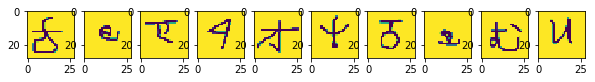

tensor([1, 6, 3, 4, 7, 9, 0, 5, 2, 8])
test


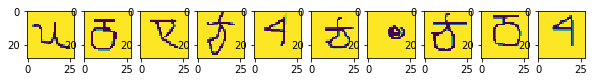

tensor([8, 0, 3, 1, 4, 1, 6, 1, 0, 4])


In [8]:
meta_train_task_loader = TaskLoader(
    OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot)
)

print(len(meta_train_task_loader.taskset))

for i, meta_train_task in enumerate(meta_train_task_loader):
    print(meta_train_task["task"])
    print("train")
    local_task_train_data_loader = meta_train_task["train"]
    for data, target in local_task_train_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
    print("test")
    local_task_test_data_loader = meta_train_task["test"]
    for data, target in local_task_test_data_loader:
        plt.figure(figsize=(10,1))
        for j, x in enumerate(data):
            plt.subplot(1, batch_size, j+1); plt.imshow(x[0])
        plt.show()
        print(target)
        break
    if i==1:
        break

---

# MAML

In [9]:
class MetaLearner(object):
    def __init__(self):
        self.lr = 0.1
        self.momentum = 0.5
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.master_net = OmniglotNet(n_class).to(self.device)
        self.master_opt = optim.Adam(self.master_net.parameters(), lr=0.001)
        self.keys = self.master_net.state_dict().keys()
    
    def copy_params(self, from_net, to_net):
        params = {k: v for k, v in from_net.state_dict().items() if k in self.keys}
        to_net.load_state_dict(params, strict=False)
    
    def save(self, model_path):
        torch.save(self.master_net.state_dict(), model_path)
    
    def load(self, model_path):
        self.master_net.load_state_dict(torch.load(model_path))
    
    def meta_test(self):
        
        meta_test_task_loader = TaskLoader(
            OmniglotOriginTaskset("../data/omniglot_mini/", meta_train=False, n_class=n_class, n_shot=n_shot))

        test_loss, test_acc = [], []
        
        sleep(0.5)
        with tqdm(meta_test_task_loader, desc="Meta Test ", ncols=10) as _tqdm:
            for meta_test_task in _tqdm:

                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)
                faster_opt = optim.SGD(faster_net.parameters(), lr=self.lr, momentum=self.momentum)

                # make local task data loader
                local_task_train_data_loader = meta_test_task["train"]
                local_task_test_data_loader = meta_test_task["test"]

                # ----------------------------------------------------------------
                # meta test task train
                # ----------------------------------------------------------------

                for epoch in range(n_local_update):
                    _train_loss, _train_acc = train(
                        faster_net, self.device, local_task_train_data_loader, faster_opt, epoch)
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                # ----------------------------------------------------------------
                # meta test task test
                # ----------------------------------------------------------------

                _test_loss, _test_acc = test(faster_net, self.device, local_task_test_data_loader)
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        return np.mean(test_loss), np.mean(test_acc)

    
    def meta_train(self):
        
        meta_train_task_loader = TaskLoader(
            OmniglotAugmentedTaskset("../data/omniglot_mini/", meta_train=True, n_class=n_class, n_shot=n_shot))
    
        meta_grads = []
        
        test_loss, test_acc = [], []
        
        sleep(0.5)
        with tqdm(meta_train_task_loader, desc="Meta Train", ncols=10) as _tqdm:
            for meta_train_task in _tqdm:
                
                # copy master model to new branch model
                faster_net = OmniglotNet(n_class).to(self.device)
                self.copy_params(self.master_net, faster_net)

                faster_params = OrderedDict((name, param) for (name, param) in faster_net.named_parameters())
                master_params = OrderedDict((name, param) for (name, param) in self.master_net.named_parameters())

                # make local task data loader
                local_task_train_data_loader = meta_train_task["train"]
                local_task_test_data_loader = meta_train_task["test"]

                # ----------------------------------------------------------------
                # meta train task train
                # ----------------------------------------------------------------

                first_train_for_this_task = True

                for epoch in range(n_local_update):
                    
                    _train_loss = 0
                    _train_acc = 0
                    
                    for data, target in local_task_train_data_loader:
                        data, target = data.to(self.device), target.to(self.device)

                        if first_train_for_this_task:
                            
                            # manual predict
                            output = self.master_net(data)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                            
                            grads = torch.autograd.grad(loss, self.master_net.parameters(), create_graph=True)

                            first_train_for_this_task = False

                        else:
                            # manual predict
                            output = faster_net.manual_forward(data, faster_params)
                            loss = F.nll_loss(output, target)
                            pred = output.max(1, keepdim=True)[1]
                            
                            _train_loss += loss
                            _train_acc += pred.eq(target.view_as(pred)).sum().item()
                                                        
                            grads = torch.autograd.grad(loss, faster_params.values(), create_graph=True)
        
                        # manual optimize!!!
                        faster_params = OrderedDict(
                            (name, param - self.lr*grad)
                            for ((name, param), grad) in zip(faster_params.items(), grads)
                        )
                    
                    _train_loss /= len(local_task_train_data_loader.dataset)
                    _train_acc /= len(local_task_train_data_loader.dataset)
                    
                    _tqdm.set_postfix(OrderedDict(
                        epoch=epoch+1, 
                        train_loss="{:.3f}".format(_train_loss), 
                        train_acc="{:.3f}".format(_train_acc)))
                
                # ----------------------------------------------------------------
                # meta train task test
                # ----------------------------------------------------------------
                
                _test_loss = 0
                _test_acc = 0
                
                for data, target in local_task_test_data_loader:
                    data, target = data.to(self.device), target.to(self.device)

                    output = faster_net.manual_forward(data, faster_params)
                    loss = F.nll_loss(output, target) # test_loss計算するとこまではfaster_net

                    # differentiates test_loss by master_net params
                    grads = torch.autograd.grad(loss, self.master_net.parameters(), retain_graph=True)
                    grads = {name:g for ((name, _), g) in zip(faster_net.named_parameters(), grads)}
                    meta_grads.append(grads)

                    pred = output.max(1, keepdim=True)[1]
                    acc = pred.eq(target.view_as(pred)).sum()
                    
                    _test_loss += loss.item()
                    _test_acc += acc.item()
                
                _test_loss /= len(local_task_test_data_loader.dataset)
                _test_acc /= len(local_task_test_data_loader.dataset)  
                test_loss.append(_test_loss)
                test_acc.append(_test_acc)
        
        # ----------------------------------------------------------------
        # end all tasks
        # ----------------------------------------------------------------
        
        meta_grads = {k: sum(grads[k] for grads in meta_grads) for k in meta_grads[0].keys()}
        
        # using data,target from somewhere
        dumy_output = self.master_net(data)
        dumy_loss = F.nll_loss(dumy_output, target)
        
        # after dumy_loss.backward, rewrite grads
        self.master_opt.zero_grad()
        dumy_loss.backward(retain_graph=True)

        hooks = []
        for (k,v) in self.master_net.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return meta_grads[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))

        # Compute grads for current step, replace with summed gradients as defined by hook
        self.master_opt.zero_grad()
        dumy_loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        self.master_opt.step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        return np.mean(test_loss), np.mean(test_acc)

In [ ]:
meta_learner = MetaLearner()

# see normal few-shot learning
for _ in range(1):
    test_loss, test_acc = meta_learner.meta_test()
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        0, test_loss, test_acc))

for epoch in range(1000):
    
    train_loss, train_acc = meta_learner.meta_train()
    test_loss, test_acc = meta_learner.meta_test()
    
    print("# {} (meta-train-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, train_loss, train_acc))    
    print("# {}  (meta-test-task) test_loss: {:.6f}, test_acc: {:.6f}".format(
        epoch+1, test_loss, test_acc))
    
    model_path = "../model/model-epoch_{:05}-train_loss_{:0.3f}-train_acc_{:0.3f}-test_loss_{:0.3f}-test_acc_{:0.3f}.pt".format(
        epoch, train_loss, train_acc, test_loss, test_acc)
    
    meta_learner.save(model_path)
    meta_learner.load(model_path)

Meta Test : 100%|█| 20/20 [00:01<00:00, 18.86it/s, epoch=5, train_loss=0.057, train_acc=1.000]


# 1 (meta-train-task) test_loss: 0.187075, test_acc: 0.491996
# 1  (meta-test-task) test_loss: 1.946103, test_acc: 0.381579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.036, train_acc=1.000]


# 2 (meta-train-task) test_loss: 0.186854, test_acc: 0.485691
# 2  (meta-test-task) test_loss: 1.909627, test_acc: 0.415000


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.52it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 3 (meta-train-task) test_loss: 0.185483, test_acc: 0.500110
# 3  (meta-test-task) test_loss: 1.914087, test_acc: 0.406053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.69it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 4 (meta-train-task) test_loss: 0.183185, test_acc: 0.514090
# 4  (meta-test-task) test_loss: 1.892184, test_acc: 0.408421


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.76it/s, epoch=5, train_loss=0.045, train_acc=1.000]


# 5 (meta-train-task) test_loss: 0.182146, test_acc: 0.518092
# 5  (meta-test-task) test_loss: 1.914067, test_acc: 0.400263


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.67it/s, epoch=5, train_loss=0.041, train_acc=1.000]


# 6 (meta-train-task) test_loss: 0.179695, test_acc: 0.538103
# 6  (meta-test-task) test_loss: 1.887611, test_acc: 0.414474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.78it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 7 (meta-train-task) test_loss: 0.177611, test_acc: 0.548410
# 7  (meta-test-task) test_loss: 1.852755, test_acc: 0.432105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.65it/s, epoch=5, train_loss=0.051, train_acc=1.000]


# 8 (meta-train-task) test_loss: 0.177746, test_acc: 0.545614
# 8  (meta-test-task) test_loss: 1.803249, test_acc: 0.464474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.55it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 9 (meta-train-task) test_loss: 0.175405, test_acc: 0.565844
# 9  (meta-test-task) test_loss: 1.887781, test_acc: 0.408158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.17it/s, epoch=5, train_loss=0.086, train_acc=1.000]


# 10 (meta-train-task) test_loss: 0.173984, test_acc: 0.573300
# 10  (meta-test-task) test_loss: 1.802236, test_acc: 0.469211


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.46it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 11 (meta-train-task) test_loss: 0.172872, test_acc: 0.573520
# 11  (meta-test-task) test_loss: 1.816170, test_acc: 0.469737


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.49it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 12 (meta-train-task) test_loss: 0.172681, test_acc: 0.578289
# 12  (meta-test-task) test_loss: 1.798154, test_acc: 0.471316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.35it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 13 (meta-train-task) test_loss: 0.170329, test_acc: 0.593750
# 13  (meta-test-task) test_loss: 1.787825, test_acc: 0.481579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.80it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 14 (meta-train-task) test_loss: 0.168819, test_acc: 0.605757
# 14  (meta-test-task) test_loss: 1.775625, test_acc: 0.486842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.44it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 15 (meta-train-task) test_loss: 0.167813, test_acc: 0.600384
# 15  (meta-test-task) test_loss: 1.753828, test_acc: 0.497105


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.03it/s, epoch=5, train_loss=0.027, train_acc=1.000]


# 16 (meta-train-task) test_loss: 0.167314, test_acc: 0.606031
# 16  (meta-test-task) test_loss: 1.734008, test_acc: 0.502895


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.56it/s, epoch=5, train_loss=0.054, train_acc=1.000]


# 17 (meta-train-task) test_loss: 0.165252, test_acc: 0.619298
# 17  (meta-test-task) test_loss: 1.733991, test_acc: 0.505789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 18 (meta-train-task) test_loss: 0.164875, test_acc: 0.615461
# 18  (meta-test-task) test_loss: 1.769141, test_acc: 0.479474


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.96it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 19 (meta-train-task) test_loss: 0.162514, test_acc: 0.631743
# 19  (meta-test-task) test_loss: 1.705794, test_acc: 0.519737


Meta Test : 100%|█| 20/20 [00:01<00:00, 11.45it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 20 (meta-train-task) test_loss: 0.161378, test_acc: 0.637445
# 20  (meta-test-task) test_loss: 1.753370, test_acc: 0.488421


Meta Test : 100%|█| 20/20 [00:01<00:00, 14.36it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 21 (meta-train-task) test_loss: 0.160974, test_acc: 0.639145
# 21  (meta-test-task) test_loss: 1.684429, test_acc: 0.534737


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.87it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 22 (meta-train-task) test_loss: 0.160212, test_acc: 0.637719
# 22  (meta-test-task) test_loss: 1.700697, test_acc: 0.536053


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.80it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 23 (meta-train-task) test_loss: 0.158175, test_acc: 0.649287
# 23  (meta-test-task) test_loss: 1.672521, test_acc: 0.531579


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.11it/s, epoch=5, train_loss=0.036, train_acc=1.000]


# 24 (meta-train-task) test_loss: 0.155872, test_acc: 0.667160
# 24  (meta-test-task) test_loss: 1.703674, test_acc: 0.526053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.04it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 25 (meta-train-task) test_loss: 0.155525, test_acc: 0.666557
# 25  (meta-test-task) test_loss: 1.661618, test_acc: 0.541842


Meta Test : 100%|█| 20/20 [00:01<00:00, 17.00it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 26 (meta-train-task) test_loss: 0.153770, test_acc: 0.677029
# 26  (meta-test-task) test_loss: 1.663316, test_acc: 0.538947


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.037, train_acc=1.000]


# 27 (meta-train-task) test_loss: 0.153325, test_acc: 0.671491
# 27  (meta-test-task) test_loss: 1.682659, test_acc: 0.521053


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.37it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 28 (meta-train-task) test_loss: 0.151498, test_acc: 0.683388
# 28  (meta-test-task) test_loss: 1.687349, test_acc: 0.531316


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.27it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 29 (meta-train-task) test_loss: 0.151280, test_acc: 0.688048
# 29  (meta-test-task) test_loss: 1.600350, test_acc: 0.582368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.29it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 30 (meta-train-task) test_loss: 0.148817, test_acc: 0.703454
# 30  (meta-test-task) test_loss: 1.606244, test_acc: 0.562895


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.65it/s, epoch=5, train_loss=0.034, train_acc=1.000]


# 31 (meta-train-task) test_loss: 0.150107, test_acc: 0.682566
# 31  (meta-test-task) test_loss: 1.652738, test_acc: 0.536316


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.18it/s, epoch=5, train_loss=0.043, train_acc=1.000]


# 32 (meta-train-task) test_loss: 0.147984, test_acc: 0.692105
# 32  (meta-test-task) test_loss: 1.625296, test_acc: 0.563158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 33 (meta-train-task) test_loss: 0.148226, test_acc: 0.695011
# 33  (meta-test-task) test_loss: 1.621744, test_acc: 0.554474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.65it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 34 (meta-train-task) test_loss: 0.147006, test_acc: 0.697423
# 34  (meta-test-task) test_loss: 1.616732, test_acc: 0.564474


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.82it/s, epoch=5, train_loss=0.031, train_acc=1.000]


# 35 (meta-train-task) test_loss: 0.145300, test_acc: 0.706798
# 35  (meta-test-task) test_loss: 1.587793, test_acc: 0.573158


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.56it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 36 (meta-train-task) test_loss: 0.144779, test_acc: 0.703564
# 36  (meta-test-task) test_loss: 1.615270, test_acc: 0.543421


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.95it/s, epoch=5, train_loss=0.029, train_acc=1.000]


# 37 (meta-train-task) test_loss: 0.143753, test_acc: 0.705208
# 37  (meta-test-task) test_loss: 1.591753, test_acc: 0.570000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.21it/s, epoch=5, train_loss=0.038, train_acc=1.000]


# 38 (meta-train-task) test_loss: 0.142108, test_acc: 0.722533
# 38  (meta-test-task) test_loss: 1.645851, test_acc: 0.513158


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.76it/s, epoch=5, train_loss=0.035, train_acc=1.000]


# 39 (meta-train-task) test_loss: 0.141693, test_acc: 0.719737
# 39  (meta-test-task) test_loss: 1.601100, test_acc: 0.555526


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.53it/s, epoch=5, train_loss=0.026, train_acc=1.000]


# 40 (meta-train-task) test_loss: 0.141462, test_acc: 0.721162
# 40  (meta-test-task) test_loss: 1.595633, test_acc: 0.565789


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.30it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 41 (meta-train-task) test_loss: 0.140522, test_acc: 0.725000
# 41  (meta-test-task) test_loss: 1.584411, test_acc: 0.563947


Meta Test : 100%|█| 20/20 [00:00<00:00, 20.10it/s, epoch=5, train_loss=0.039, train_acc=1.000]


# 42 (meta-train-task) test_loss: 0.139840, test_acc: 0.728344
# 42  (meta-test-task) test_loss: 1.611404, test_acc: 0.538421


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.09it/s, epoch=5, train_loss=0.032, train_acc=1.000]


# 43 (meta-train-task) test_loss: 0.139521, test_acc: 0.726042
# 43  (meta-test-task) test_loss: 1.612095, test_acc: 0.540789


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.99it/s, epoch=5, train_loss=0.020, train_acc=1.000]


# 44 (meta-train-task) test_loss: 0.137773, test_acc: 0.732072
# 44  (meta-test-task) test_loss: 1.552411, test_acc: 0.568684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.018, train_acc=1.000]


# 45 (meta-train-task) test_loss: 0.137361, test_acc: 0.731908
# 45  (meta-test-task) test_loss: 1.533529, test_acc: 0.587368


Meta Test : 100%|█| 20/20 [00:01<00:00, 18.74it/s, epoch=5, train_loss=0.028, train_acc=1.000]


# 46 (meta-train-task) test_loss: 0.136680, test_acc: 0.740132
# 46  (meta-test-task) test_loss: 1.528798, test_acc: 0.588684


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.33it/s, epoch=5, train_loss=0.024, train_acc=1.000]


# 47 (meta-train-task) test_loss: 0.135871, test_acc: 0.738980
# 47  (meta-test-task) test_loss: 1.578581, test_acc: 0.550000


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.94it/s, epoch=5, train_loss=0.021, train_acc=1.000]


# 48 (meta-train-task) test_loss: 0.134987, test_acc: 0.744189
# 48  (meta-test-task) test_loss: 1.550080, test_acc: 0.574474


Meta Test : 100%|█| 20/20 [00:01<00:00, 19.07it/s, epoch=5, train_loss=0.022, train_acc=1.000]


# 49 (meta-train-task) test_loss: 0.135039, test_acc: 0.739254
# 49  (meta-test-task) test_loss: 1.504745, test_acc: 0.603947


Meta Train:  39%|▍| 37/96 [00:21<00:33,  1.76it/s, epoch=5, train_loss=0.024, train_acc=1.000]